In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on Tori

This notebook shows how define and evaluate kernels on the two-dimensional torus $\mathbb{T}^2$.

Any torus $\mathbb{T}^d$ is a *product manifold* $\mathbb{T}^d = \mathbb{T}^1 \times \ldots \times \mathbb{T}^1$ where $\mathbb{T}^1 = \mathbb{S}_1$ is the circle.
So this notebook also shows the basics of working with product manifolds.

**Note:** the kind of torus we consider here (product of circles) is the *flat torus*.
Its Riemannian geometry is different from the Riemannian geometry that the often-visualized donut shape inherits from the ambient $\mathbb{R}^3$.
Rather than that, its Riemannian geometry is the geometry of the product manifold while the geometry of each individual circle is inherited from the ambient $\mathbb{R}^2$ space.
It follows that $\mathbb{T}^d$ can be embedded in $\mathbb{R}^{2 d}$ and the Riemannian geometry that this embedding inherits from the ambient $\mathbb{R}^{2 d}$ coincides with the Riemannian geometry of the flat torus.
It is useful to think of the flat torus as the square ($d$-dimensional hypercube) with opposite sides glued together.
Another way to think about the flat torus is that functions on the flat torus are exactly $2 \pi$-periodic functions (in each of the variables) on $\mathbb{R}^d$.

We use the **numpy** backend here.

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualize Kernels](#Visualize-Kernels)
  - [Product Kernel vs Kernel on the Product Space](#Product-Kernel-vs-Kernel-on-the-Product-Space)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
  - [Feature Maps and Sampling for Product Kernels](#Feature-Maps-and-Sampling-for-Product-Kernels)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import the spaces and an appropriate kernel.
from geometric_kernels.spaces import Circle, ProductDiscreteSpectrumSpace
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


### Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional torus $\mathbb{T}^2$.
We use `ProductDiscreteSpectrumSpace` which takes a number of `DiscreteSpectrumSpace` instances (e.g. `Circle()`) and constructs their product space.

`ProductDiscreteSpectrumSpace` has an optional parameter `num_levels` which determines the *maximal* order of approximation of the kernel (*number of levels*).
`ProductDiscreteSpectrumSpace` uses the parameter `num_levels` for precomputation.
There is a sensible default value for this parameter, so change it only if you know what you are doing.

In [3]:
torus = ProductDiscreteSpectrumSpace(Circle(), Circle())

### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `torus` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on product spaces can be found on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/product_spaces.html).

In [4]:
kernel = MaternGeometricKernel(torus)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
LENGTHSCALE = 0.5

params["lengthscale"] = np.array([LENGTHSCALE])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

### Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on the torus $\mathbb{T}^2$

In [7]:
key = np.random.RandomState(1234)

key, xs = torus.random(key, 10)

print(xs)

[[1.2033522  2.24823221]
 [3.90882469 3.14784521]
 [2.7503245  4.29432427]
 [4.93455351 4.4780389 ]
 [4.90073254 2.3263541 ]
 [1.71274985 3.52609963]
 [1.73707615 3.16096475]
 [5.03831148 0.08650972]
 [6.02016711 4.85581287]
 [5.50364706 5.54579816]]


Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

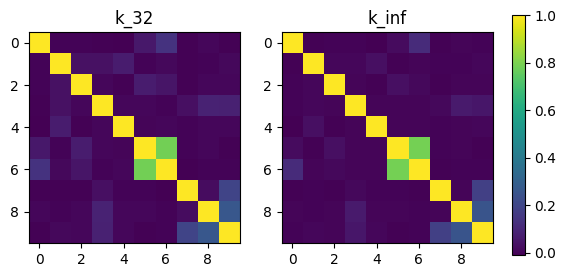

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualize Kernels

The torus $\mathbb{T}^2$ is one of the few manifolds we can easily visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(\text{pole}, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We represent the torus as the square whose sides are assumed to be glued.

We define `base_point` and `other_points` in the next cell.

In [10]:
base_point = np.array([[np.pi, 0.0]])

# define discretization
_NUM_PTS = 128

# generate a grid on the torus
x1s, x2s =  np.mgrid[0:2*np.pi:_NUM_PTS*1j, 0:2*np.pi:_NUM_PTS*1j]
other_points = np.c_[np.ravel(x1s), np.ravel(x2s)]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32  = kernel.K(params_32,  base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, base_point, other_points)

Finally, we are ready to plot the results.

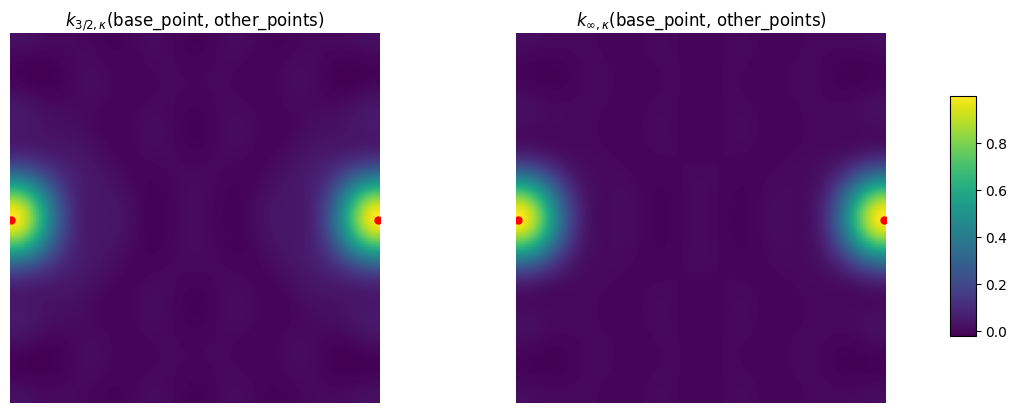

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2)

cmap = plt.get_cmap('viridis')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

ax1.imshow( kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)
ax2.imshow(kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)

# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)


ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

Notice how the kernel is getting "cut" on the left and continues on the right.
This is because the sides of this rectangle are actually glued together.

### Product Kernel vs Kernel on the Product Space

Here we describe an alternative way to define a kernel on torus, as a product kernel.
The theory behind such kernels is briefly described on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/product_kernels.html).

Basically, a product kernel is a product of kernels. The advantage of using it is that it maintains a separate lengthscale for each of the factors of the product space, i.e. for each of the circles that make the torus.
This allows you to use ARD, as in [Rasmussen and Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf).
Also, we only support products of discrete spectrum spaces (via `ProductDiscreteSpectrumSpace`), whereas product kernels (`ProductGeometricKernel`) can be defined on arbitrary products of GeometricKernels spaces.

**Note:** product kernels do not coincide with kernels on product spaces unless $\nu = \infty$ and all lengthscales coincide. We will demonstrate this below.

We import the `ProductGeometricKernel` class

In [13]:
from geometric_kernels.kernels import ProductGeometricKernel

We define a new generic `product_kernel` as the product of two `MaternKarhunenLoeveKernel` on the `Circle`, initialize and set its paramters.

In [14]:
product_kernel = ProductGeometricKernel(MaternGeometricKernel(Circle(), 30),
                                        MaternGeometricKernel(Circle(), 30))
product_params = product_kernel.init_params()
print('params:', product_params)

product_params["lengthscale"] = np.array([LENGTHSCALE, LENGTHSCALE])
product_params_32  = product_params.copy()
product_params_inf = product_params.copy()
del product_params
product_params_32["nu"]  = np.array([3/2, 3/2])
product_params_inf["nu"] = np.array([np.inf, np.inf])

params: {'nu': array([inf, inf]), 'lengthscale': array([1., 1.])}


Next we compute the value of the `product_kernel` for $\nu = 3/2$ and for $\nu = \infty$. After this we compute the difference between the values of the `product_kernel` and the `kernel`.

In [15]:
product_kernel_vals_32  = product_kernel.K(product_params_32,  base_point, other_points)
product_kernel_vals_inf = product_kernel.K(product_params_inf, base_point, other_points)
product_diff_32  = np.abs(kernel_vals_32  - product_kernel_vals_32)
product_diff_inf = np.abs(kernel_vals_inf - product_kernel_vals_inf)

We visualize the `kernel` and `product_kernel` for $\nu = 3/2$ as well as the difference between them.

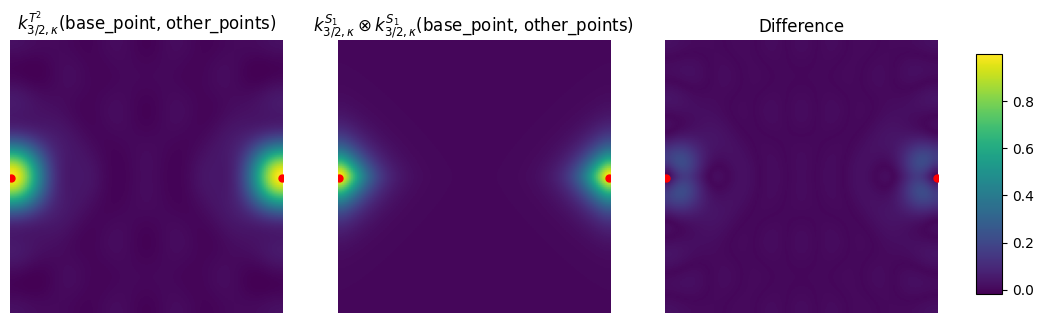

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=3)

cmap = plt.get_cmap('viridis')

# find common range of values
product_minmin_vis_32 = np.min([np.min(kernel_vals_32), np.min(product_kernel_vals_32)])
product_maxmax_vis_32 = np.max([np.max(kernel_vals_32), np.max(product_kernel_vals_32)])

ax1.imshow(        kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)
ax2.imshow(product_kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)
ax3.imshow(       product_diff_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax3.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)

ax1.set_title(r'$k_{3/2, \kappa}^{T^2}($base_point, other_points$)$')
ax2.set_title('$k_{3/2, \kappa}^{S_1} \otimes k_{3/2, \kappa}^{S_1}($base_point, other_points$)$')
ax3.set_title('Difference')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

We see that the `kernel` differs from the `product_kernel`, despite having the same parameters.

We visualize the `kernel` and `product_kernel` for $\nu = \infty$ as well as the difference between them.

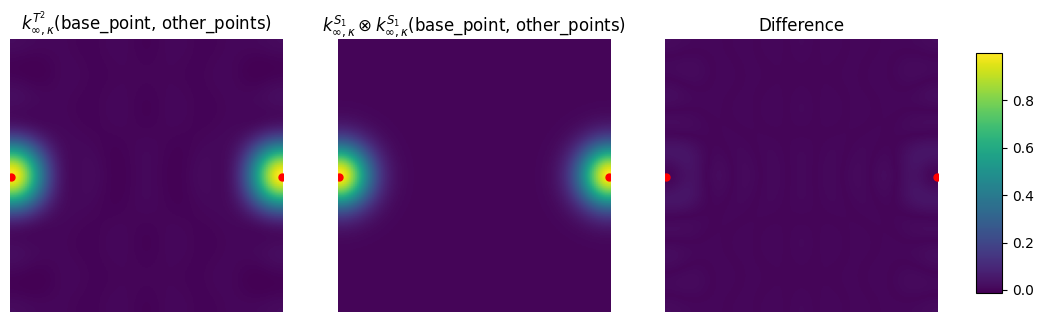

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=3)

cmap = plt.get_cmap('viridis')

# find common range of values
product_minmin_vis_inf = np.min([np.min(kernel_vals_inf), np.min(product_kernel_vals_inf)])
product_maxmax_vis_inf = np.max([np.max(kernel_vals_inf), np.max(product_kernel_vals_inf)])

ax1.imshow(        kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)
ax2.imshow(product_kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)
ax3.imshow(       product_diff_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax3.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)

ax1.set_title(r'$k_{\infty, \kappa}^{T^2}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}^{S_1} \otimes k_{\infty, \kappa}^{S_1}($base_point, other_points$)$')
ax3.set_title('Difference')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

We see that the `kernel` and the `product_kernel` are the same in this case, as theory predicts.

## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the torus, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [18]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the (hyper)torus, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `ProductDiscreteSpectrumSpace` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [19]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 2)):
[[1.2033522  2.24823221]
 [3.90882469 3.14784521]
 [2.7503245  4.29432427]
 [4.93455351 4.4780389 ]
 [4.90073254 2.3263541 ]
 [1.71274985 3.52609963]
 [1.73707615 3.16096475]
 [5.03831148 0.08650972]
 [6.02016711 4.85581287]
 [5.50364706 5.54579816]]

emedding (shape = (10, 79)):
[[ 2.20941641e-01 -1.77201327e-01  2.20282049e-01  1.01558006e-01
   2.63837948e-01 -8.20588337e-02  1.02008762e-01 -2.13180970e-01
   2.65008968e-01 -4.67241284e-02 -2.13017530e-01 -1.61796025e-01
   1.46224685e-01 -2.20048929e-02 -1.00321356e-01 -5.71665986e-02
  -2.60625250e-01  1.32953172e-01 -1.65276398e-01 -1.20157684e-01
   1.49370104e-01  3.70909012e-02  1.69099188e-01 -3.35212520e-02
  -1.52824987e-01  1.38996113e-01  6.91272842e-02 -1.38512143e-01
  -7.00919906e-02  6.66250650e-02  3.31348101e-02  1.73085521e-01
   8.60810549e-02  1.15844560e-01 -1.44008385e-01  5.86214004e-02
  -7.28732814e-02 -1.17277704e-01 -5.83260139e-02  1.05990832e-01
   5.27126854e-02  3.37500180e-02  1.

### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [20]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.31634816 -2.38559012]
 [-0.61819585  0.12209121]
 [ 0.8101087  -1.70702319]
 [-0.63509083  1.0057374 ]
 [ 0.1851223   0.51089693]
 [ 0.02621555  0.15314556]
 [-0.19946012  0.37070016]
 [ 0.25204997 -0.28420479]
 [-0.92386637  1.50608757]
 [ 2.0426702  -0.31522709]]


#### Visualizing Samples
Here we visualize samples as functions on the torus.

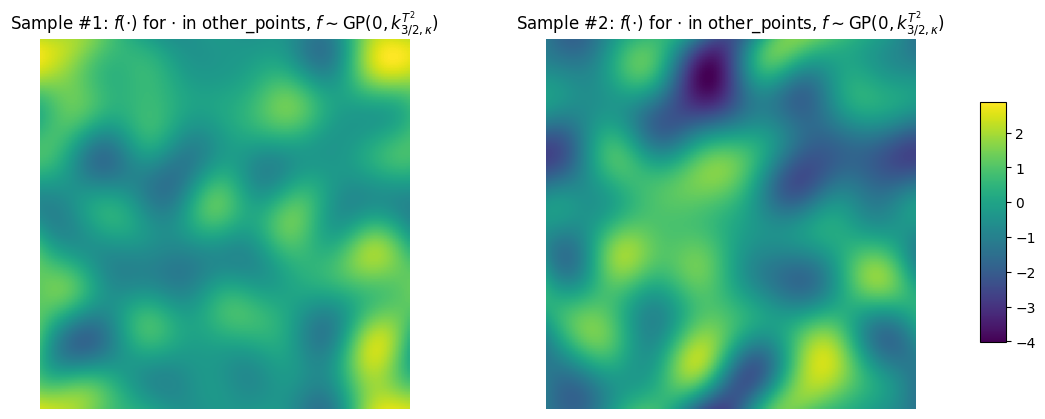

In [21]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2)

cmap = plt.get_cmap('viridis')

# find common range of values
minmin_vis = np.min([np.min(sample1), np.min(sample2)])
maxmax_vis = np.max([np.max(sample1), np.max(sample2)])

ax1.imshow(sample1.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)
ax2.imshow(sample2.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)

# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()

ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa}^{T^2})$')
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa}^{T^2})$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Feature Maps and Sampling for Product Kernels
This functionality is not implemented yet, unfortunately.

## Citation

If you are using (hyper)tori and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@inproceedings{borovitskiy2020,
    title={Matérn Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}
}
```